<a href="https://colab.research.google.com/github/seodalzzz/Machine_Learning_implementation/blob/main/tSNE_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import seaborn as sns

In [ ]:
# MNIST, CIFAR10, CIFAR100
trainset = torchvision.datasets.MNIST(root='./datasets/', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./datasets/', train=False,
                                       download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 138737390.36it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97768921.57it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 83776182.24it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6703212.09it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
#trainloader = torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=1000,shuffle=True) # try later
testloader = torch.utils.data.DataLoader(testset,batch_size=1000,shuffle=True)

In [ ]:
dataiter = iter(trainloader)
tr_images, tr_labels = next(iter(dataiter))
tr_images, tr_labels = tr_images.numpy(), tr_labels.numpy()
tr_images, tr_labels = tr_images.reshape(len(tr_images),-1), tr_labels.reshape(len(tr_labels),-1)

In [ ]:
dataiter = iter(testloader)
te_images, te_labels = next(iter(dataiter))
te_images, te_labels = te_images.numpy(), te_labels.numpy()
te_images, te_labels = te_images.reshape(len(te_images),-1), te_labels.reshape(len(te_labels),-1)

In [ ]:
class PCA():
    def __init__(self, num_components):
        print("PCA initialized..")

        self.k=num_components
        self.meanvec=np.zeros(1000)
        self.V=np.zeros((1000,1000))

    def fit(self, X): #tr_images(60000*784로 들어옴)
        self.meanvec=X.mean(axis=0)
        Xc=X-self.meanvec
        Sigma=np.cov(Xc, rowvar=False)

        Q=np.zeros((Sigma.shape[0],Sigma.shape[0]))
        eigenvalues, Q =np.linalg.eig(Sigma)

        arg_idx=eigenvalues.argsort()[::-1]
        arg_idx_topk=arg_idx[:self.k]
        self.V=Q[:,arg_idx_topk]

        X_reduced=np.dot(Xc,self.V)
        return X_reduced

    def fit_transform(self, X):

        Xc=X
        Xc=X-self.meanvec
        X_reduced=np.dot(Xc,self.V)
        return X_reduced

    def reconstruct(self, X_reduced):
        X_reconstruction=np.dot(X_reduced,self.V.T)+self.meanvec
        return X_reconstruction

In [ ]:
class tSNE:
    def __init__(self, perp, lr, num_dim=2, num_epoch=500):
        print("tSNE initialized..")

        self.num_dim = num_dim
        self.num_epoch = num_epoch
        self.perp = perp # sigma
        self.lr = lr
        self.sigma_exp=np.zeros(num_dim)

    def compute_p_single(self, X, i, j):
        xi,xj=X[i],X[j]
        numerator=np.exp(-np.linalg.norm(xi-xj)**2)/(2*self.perp**2)
        return numerator

    def compute_p(self, X):
        P=np.zeros((X.shape[0],X.shape[0]))
        for i in range(X.shape[0]):
          for j in range(X.shape[0]):
            if i>j:
              p=self.compute_p_single(X,i,j)
              P[i,j]=p
              P[j,i]=p

        p1=np.sum(P,axis=1,keepdims=True)
        p2=np.sum(P,axis=0,keepdims=True).T
        return (np.divide(P,p1)+np.divide(P,p2))/(2*X.shape[0])

    def compute_q_single(self, y, i, j):
        yi,yj=y[i],y[j]
        numerator=(1+np.linalg.norm(yi-yj)**2)**(-1)
        return numerator

    def compute_q(self, y):
        # t-distribution
        Q=np.zeros((y.shape[0],y.shape[0]))
        for i in range(y.shape[0]):
          for j in range(y.shape[0]):
            if i>j:
              q=self.compute_q_single(y,i,j)
              Q[i,j],Q[j,i]=q,q
        Q_unnormalize=Q
        Q/=np.sum(Q)
        return Q, Q_unnormalize

    def fit(self, X):

          P=self.compute_p(X)
          # initialize low-dimensional embedding y using PCA
          pca=PCA(num_components=2)
          y=pca.fit(X)

          #KL divergence 구할 때 log(diag)=0 으로 만들어서 그냥 diag 포함해서 다 더하면 되도록 > 원래 P는 diag =0 인데 diag=1로 만들어줌
          P[range(X.shape[0]), range(X.shape[0])]=1

          for iteration in range(self.num_epoch):
            Q,Q_unnormalize=self.compute_q(y)
            Q[range(X.shape[0]), range(X.shape[0])]=1.
            loss=np.sum(np.multiply(P, np.log(P+1e-10)-np.log(Q+1e-10))) #KL divergence
            grad=np.zeros(y.shape)
            for i in range(y.shape[0]):
              grad[i]=np.sum(np.tile(P[:,i]-Q[:,i],(self.num_dim,1)).T*(y[i,:]-y)*np.tile(Q_unnormalize[:,i],(self.num_dim,1)).T,0)
            y-=grad*self.lr
            if iteration % 10==0:
              print("Epoch %d: Loss=%.2f"%(iteration,loss))
          return y


In [ ]:
#model = tSNE(perp=1e+1,lr=1e+4) # for 100 data instances
model = tSNE(perp=5e+0,lr=1e+6) # for 1000 data instances

tSNE initialized..


In [ ]:
tr_images_reduced = model.fit(tr_images)
tr = np.hstack([tr_images_reduced,tr_labels])

PCA initialized..


<ipython-input-7-21afbad9c2c3>:91: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[i]=np.sum(np.tile(P[:,i]-Q[:,i],(self.num_dim,1)).T*(y[i,:]-y)*np.tile(Q_unnormalize[:,i],(self.num_dim,1)).T,0)


Epoch 0: Loss=5.25
Epoch 10: Loss=5.22
Epoch 20: Loss=5.19
Epoch 30: Loss=5.16
Epoch 40: Loss=5.14
Epoch 50: Loss=5.11
Epoch 60: Loss=5.09
Epoch 70: Loss=5.07
Epoch 80: Loss=5.06
Epoch 90: Loss=5.04
Epoch 100: Loss=5.02
Epoch 110: Loss=5.01
Epoch 120: Loss=5.00
Epoch 130: Loss=4.99
Epoch 140: Loss=4.97
Epoch 150: Loss=4.96
Epoch 160: Loss=4.95
Epoch 170: Loss=4.95
Epoch 180: Loss=4.94
Epoch 190: Loss=4.93
Epoch 200: Loss=4.92
Epoch 210: Loss=4.91
Epoch 220: Loss=4.91
Epoch 230: Loss=4.90
Epoch 240: Loss=4.89
Epoch 250: Loss=4.89
Epoch 260: Loss=4.88
Epoch 270: Loss=4.88
Epoch 280: Loss=4.87
Epoch 290: Loss=4.87
Epoch 300: Loss=4.86
Epoch 310: Loss=4.86
Epoch 320: Loss=4.85
Epoch 330: Loss=4.85
Epoch 340: Loss=4.84
Epoch 350: Loss=4.84
Epoch 360: Loss=4.83
Epoch 370: Loss=4.83
Epoch 380: Loss=4.83
Epoch 390: Loss=4.82
Epoch 400: Loss=4.82
Epoch 410: Loss=4.81
Epoch 420: Loss=4.81
Epoch 430: Loss=4.81
Epoch 440: Loss=4.80
Epoch 450: Loss=4.80
Epoch 460: Loss=4.79
Epoch 470: Loss=4.79
Epo

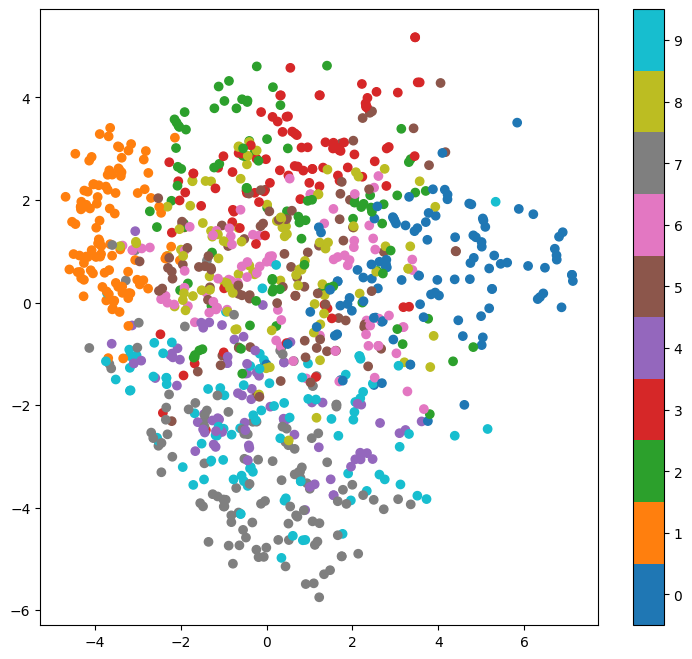

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

colors = ListedColormap(sns.color_palette())

plt.figure(figsize=(9,8))

plt.scatter(tr[:,0],tr[:,1],c=tr[:,2],cmap=colors)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9])
plt.clim(-.5,9.5)

plt.show()
plt.close()